In [9]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import warnings
from glob import glob
import subprocess as s
warnings.filterwarnings("ignore")

from astropy.io import fits
from scipy.optimize import curve_fit
# from astropy.visualization import astropy_mpl_style
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# plt.style.use(astropy_mpl_style)
plt.style.use('default')
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel
from astropy.io import fits
import numpy as np
kernel = Gaussian2DKernel(x_stddev=1)



# 1. basic setting

In [3]:
'''
export SAS_CCF=/stage/headat/yanling/xmm/0502020201/ccf.cif
export SAS_ODF=/stage/headat/yanling/xmm/0502020201/1378_0502020101_SCX00000SUM.SAS

export SAS_CCF=/stage/headat/yanling/xmm/0502020101/ccf.cif
export SAS_ODF=/stage/headat/yanling/xmm/0502020101/1378_0502020101_SCX00000SUM.SAS

'''
bkg_dir = '/stage/headat/yanling/xmm/fwc_dat_2023-06-30'
os.makedirs(bkg_dir, exist_ok=True)
os.chdir(bkg_dir)

# filter time of full-time background to the observing time

calcualte seconds from ref time

In [ ]:
# The TIME is expressed in terms of number of seconds since the reference time (1998-01-01T00:00:00) 
# the observe date of A222/223 of xmm is OBS1: 2007.6.18-19, OBS2:2007.6.22-23
# for mos: take the time +/- 150 days, same as xisnxbgen
# for pn: take +/- 1.5yr, 
# in XMM evqpb, they take two times of obs exp time centered by obs time
from datetime import datetime

date_format = '%Y-%m-%d %H:%M:%S'

# Example dates
date1 = '1998-01-01 00:00:00'
date2 = '2007-06-11 00:00:00'

# Convert dates to datetime objects
datetime1 = datetime.strptime(date1, date_format)
datetime2 = datetime.strptime(date2, date_format)

# Calculate the difference in seconds
difference_in_seconds = (datetime2 - datetime1).total_seconds()

print(difference_in_seconds)
print(f'for mos: {int(difference_in_seconds - 150*24*3600)}, {int(difference_in_seconds + 150*24*3600)}')
print(f'for pn: {int(difference_in_seconds - 365*1.5*24*3600)}, {int(difference_in_seconds + 365*1.5*24*3600)}')



filter the time and the energy band of the bkg event


In [ ]:
bands = ['700-1200', '1200-2000', '2000-5000', '5000-7000']

os.chdir(bkg_dir)
os.makedirs('events/', exist_ok=True)
os.makedirs('imgs/', exist_ok=True)
f = open(f'events/filter_bkg_time.sh', 'w')
files = glob.glob('events/mos*.fits.gz')
for file in files:
    file = file.split('/')[-1]
    # TIME>=250603200 && TIME<=345211200"  don't filter time when extracting spectra!
    # f.write(f'evselect table={file} expression="withfilteredset=yes filteredset=events/{file.split(".")[0]}_obstime.fits"\n')
    if 'mos' in file:
        pattern = 12
        ins = 'EM'
        if 'mos1' in file:
            express = f'#XMMEA_{ins}&&(PATTERN<={pattern})&&FLAG==0&&(CCDNR.ne.6)' # (PI in [{blo}:{bhi}])&&
        else:
            express = f'#XMMEA_{ins}&&(PATTERN<={pattern})&&FLAG==0'
    else:
        pattern = 4
        ins = 'EP'
        express = f'#XMMEA_{ins}&&(PATTERN<={pattern})&&FLAG==0'
    for band in bands:
        blo = band.split('-')[0]
        bhi = band.split('-')[1]
        f.write(f'evselect table=events/{file.split(".")[0]}_obstime.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 \
yimagebinsize=80 withimageset=true imageset=imgs/{file.split(".")[0]}_obstime_{band}_img.fits \
expression="{express}"\n')
        f.write(f'evselect table=events/{file.split(".")[0]}_obstime.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 \
yimagebinsize=80 withimageset=true imageset=imgs/{file.split(".")[0]}_obstime_{band}_img.fits \
expression="{express}"\n')

f.close()

# sh events/filter_bkg_time.sh

check if bkg event exp time < 230400 s, and how much is it

In [ ]:

fitsheader mos1_closed_FF_2022_v2_obstime.fits | grep LIVETIME
LIVETIME = 2.01623987500000E+06 / [s] Full time interval for the exposure

check the image

(648, 648)


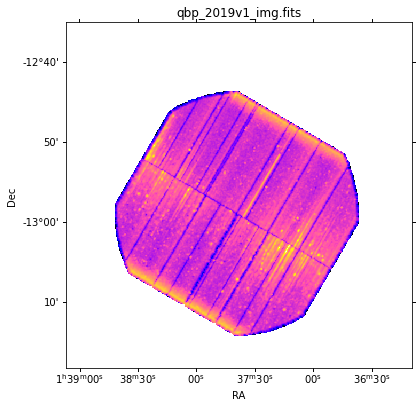

(648, 648)


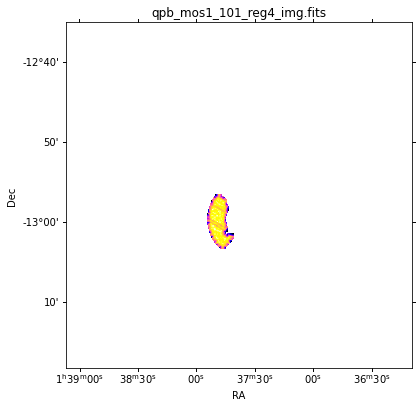

(648, 648)


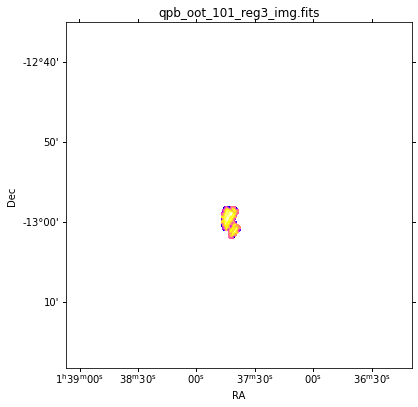

(648, 648)


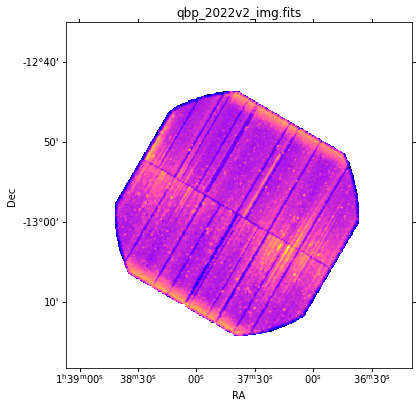

(648, 648)


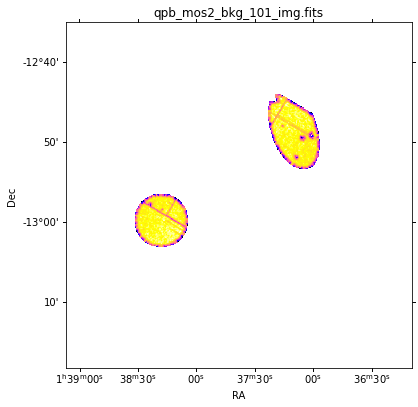

(648, 648)


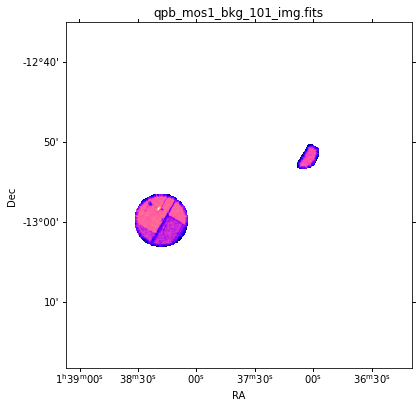

(648, 648)


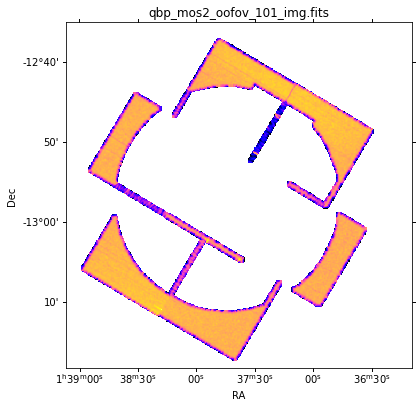

(648, 648)


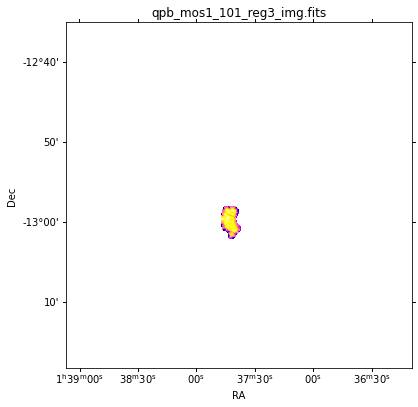

(648, 648)


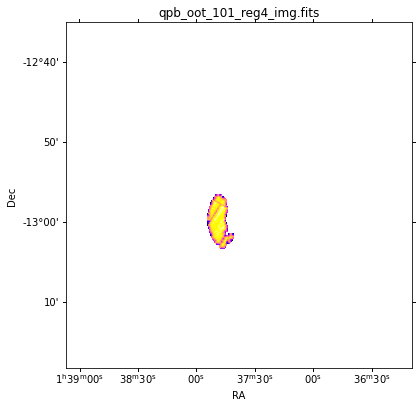

(648, 648)


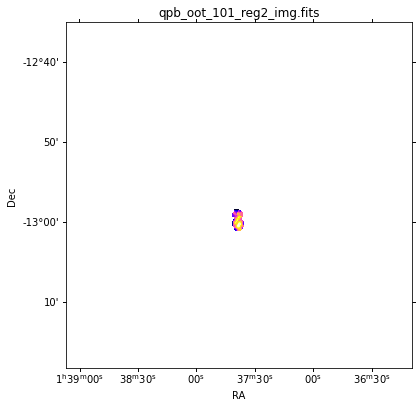

(648, 648)


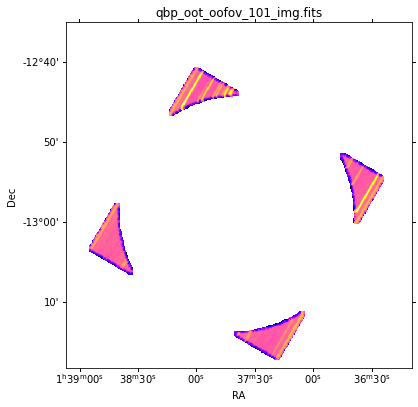

(648, 648)


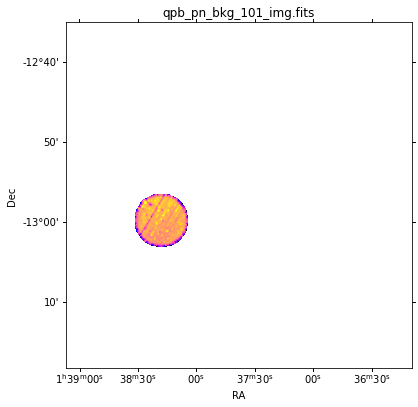

(648, 648)


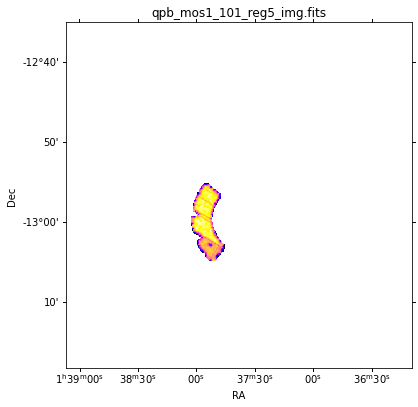

(648, 648)


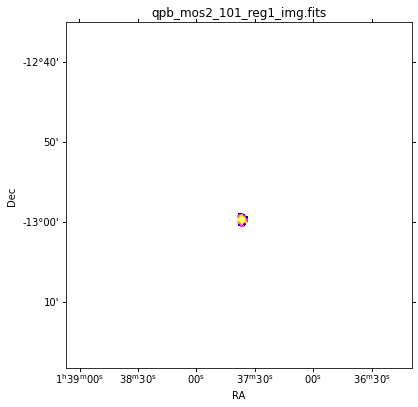

(648, 648)


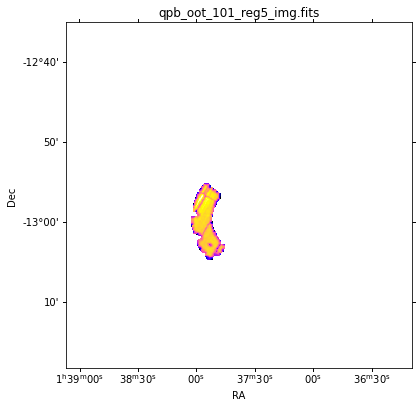

(648, 648)


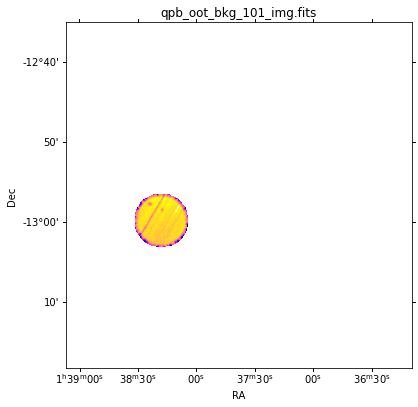

(648, 648)


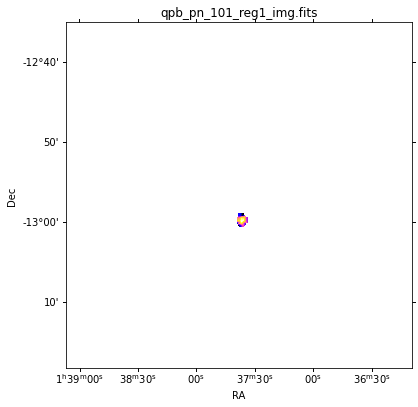

(648, 648)


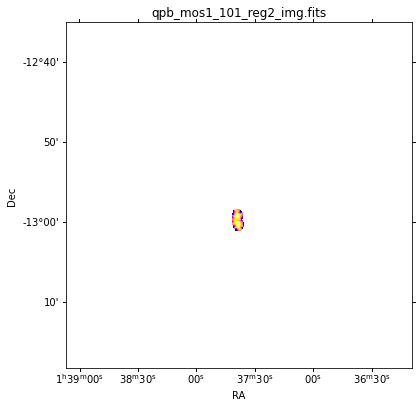

(648, 648)


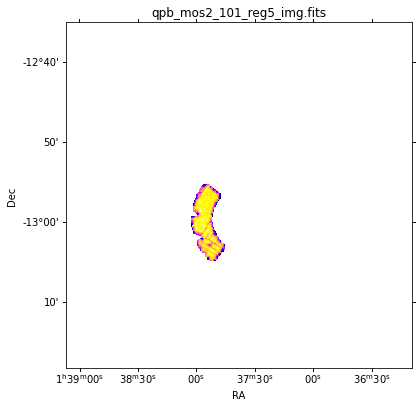

(648, 648)


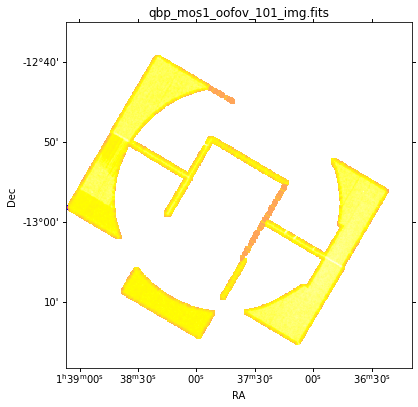

(648, 648)


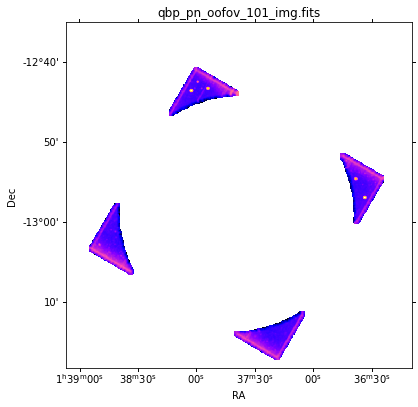

(648, 648)


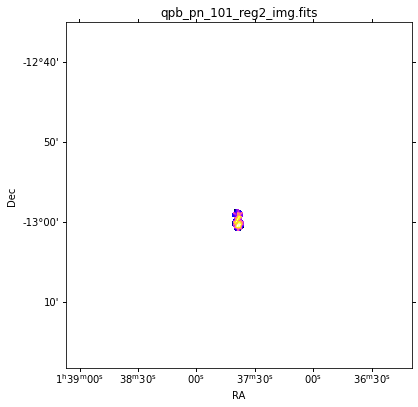

(648, 648)


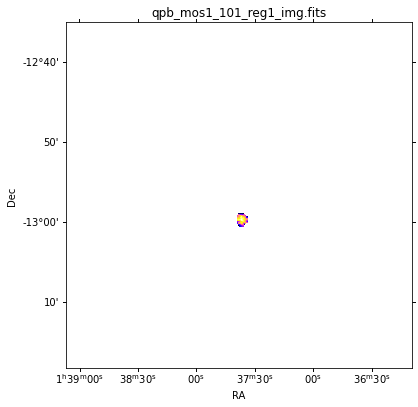

(648, 648)


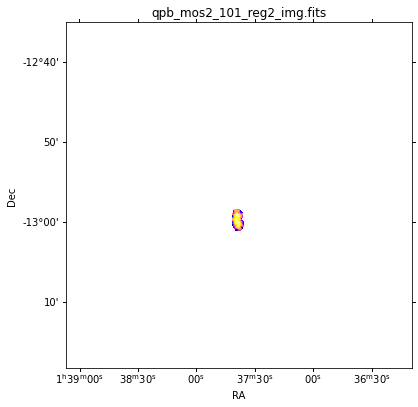

(648, 648)


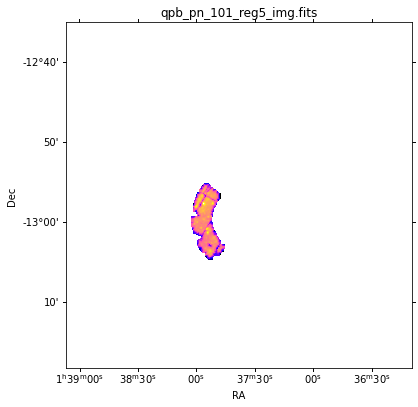

(648, 648)


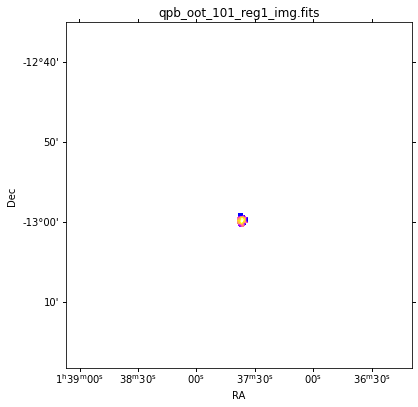

(648, 648)


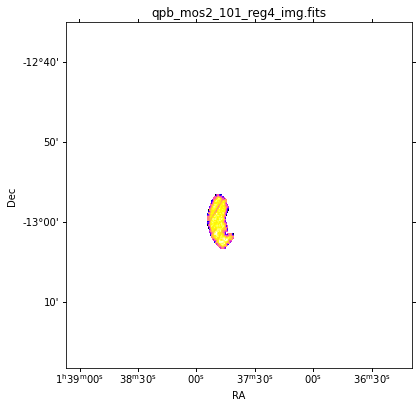

(648, 648)


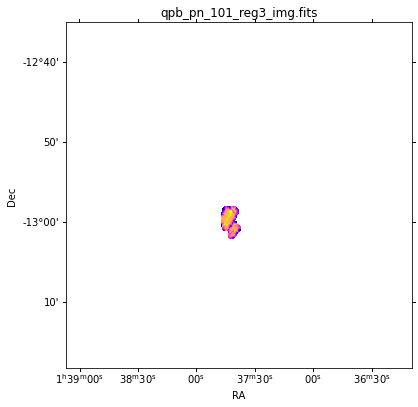

(648, 648)


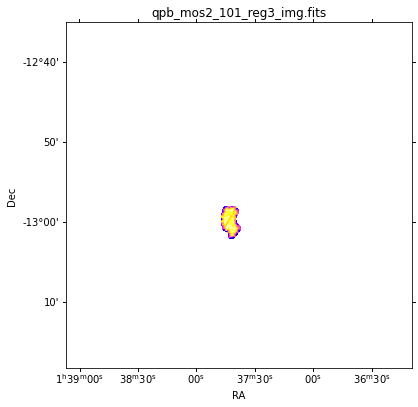

(648, 648)


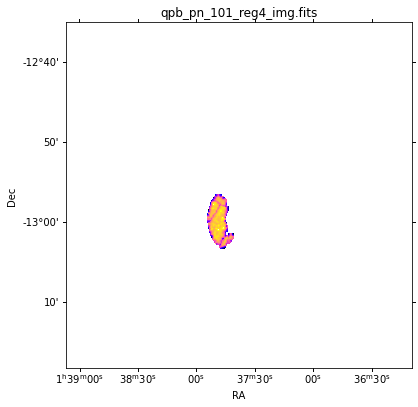

In [15]:
os.chdir(bkg_dir)
os.makedirs('png', exist_ok=True)

for file in glob(f'*_img.fits'):
    title = file
    hdu = fits.open(f'{file}')[0]
    image_data = hdu.data
    print(image_data.shape)
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=WCS(f'{file}'))
    ra = ax.coords[0]
    dec = ax.coords[1]

    ra.set_axislabel('RA')
    dec.set_axislabel('Dec')
    image_data = np.where(np.isfinite(np.log10(image_data)), image_data, np.nan)
    astropy_conv = convolve(image_data, kernel)
    ax.set_title(title)
    # print(np.nanmax(np.log10(image_data)), np.nanmin(np.log10(image_data)[image_data>0]))
    ax.matshow(np.log10(astropy_conv), cmap='gnuplot2',origin='lower')
    # plt.colorbar()
    plt.savefig(f'png/{os.path.basename(file).split(".")[0]}.png')
    plt.show()
    plt.close()


# 2. extract lightcurve of the background


In [ ]:
from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')
os.makedirs('lc', exist_ok=True)
f = open(f'bkg_lc_{today}.sh', 'w')
files = glob.glob(f'events/*.fits.gz')
for file in files:
    file = file.split('.')[0].split('/')[-1]
    if 'mos' in file:
        pattern = 12
        ins = 'EM'
        if 'mos1' in file:
            express1 = f'#XMMEA_{ins}&&(PATTERN<={pattern})&&FLAG==0&&(CCDNR.ne.6) && (PI in [9000:12000])'
        else:
            express1 = f'#XMMEA_{ins}&&(PATTERN<={pattern})&&FLAG==0 && (PI in [9000:12000])'
    else:
        pattern = 4
        ins = 'EP'
        express1 = f'#XMMEA_{ins}&&(PATTERN<={pattern})&&FLAG==0&& (PI in [9000:12000])'

    express2 = f'#XMMEA_16&&(PATTERN<={pattern})&& (PI in [9000:12000])'
#     f.write(f'evselect table=events/{file}.fits.gz withrateset=Y rateset=lc/rate_{file}_bkg_fov_9-12kev.fits \
# maketimecolumn=Y timebinsize=100 makeratecolumn=Y expression="{express1}"\n')
    f.write(f'evselect table=events/{file}.fits.gz withrateset=Y rateset=lc/rate_{file}_bkg_oofov_9-12kev.fits \
maketimecolumn=Y timebinsize=100 makeratecolumn=Y expression="{express2}"\n')

f.close()
# f = open(f'bkg_lc_{today}.sh')
# print(f.readlines())
# f.close()

plot lightcone

In [ ]:
files = glob.glob(f'lc/*.fits')
print(files)
for file in files:
    file = file.split('.')[0].split('/')[-1]
    hdul = fits.open(f'lc/{file}.fits')
    dat = hdul[1].data
    hdul.close()
    plt.figure(figsize = (8,8))
    plt.scatter(dat['TIME'],dat['RATE'])#, yerr=dat['ERROR'])
    plt.axhline(0.35, color = 'r')
    plt.show()

# 3. fit gaussian of bkg data

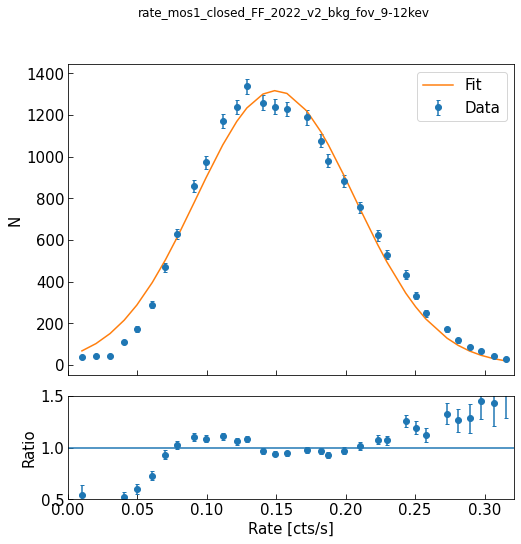

<Figure size 432x288 with 0 Axes>

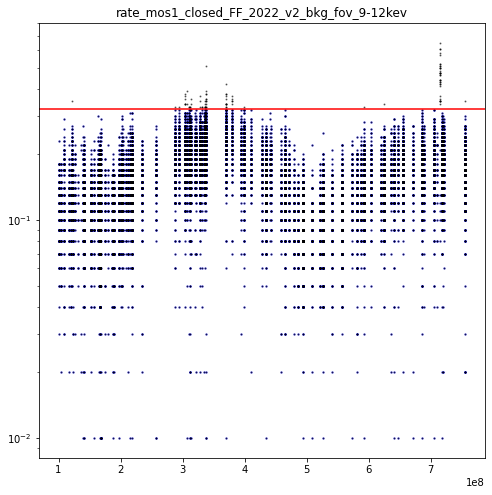

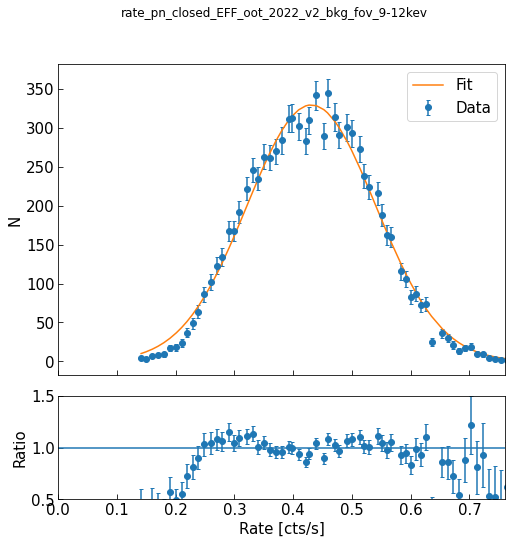

<Figure size 432x288 with 0 Axes>

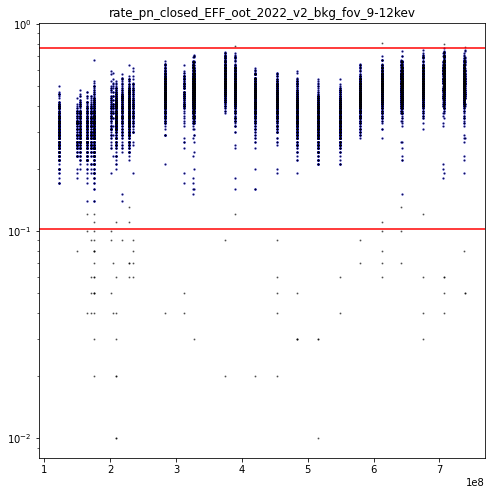

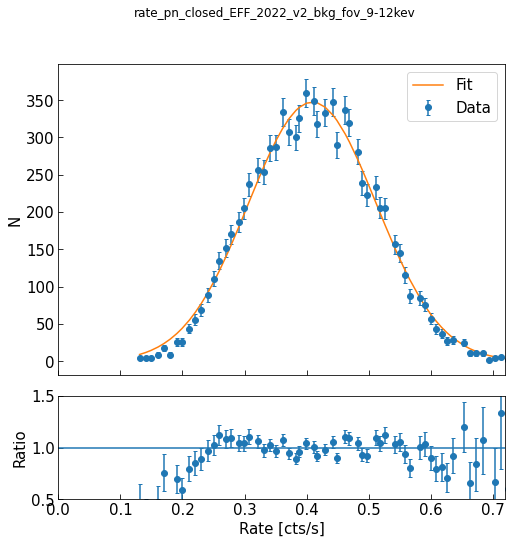

<Figure size 432x288 with 0 Axes>

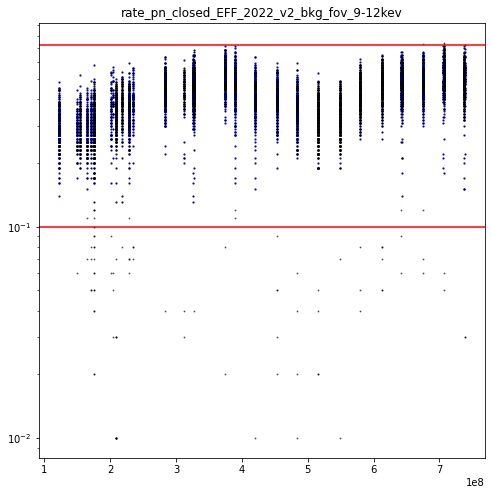

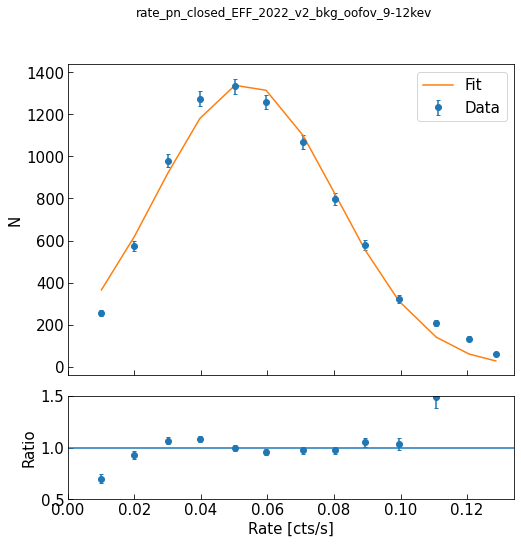

<Figure size 432x288 with 0 Axes>

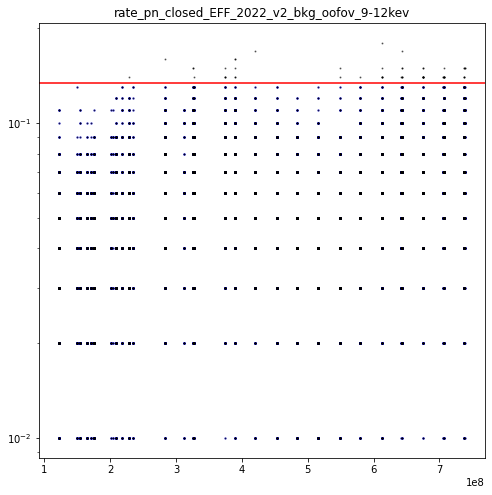

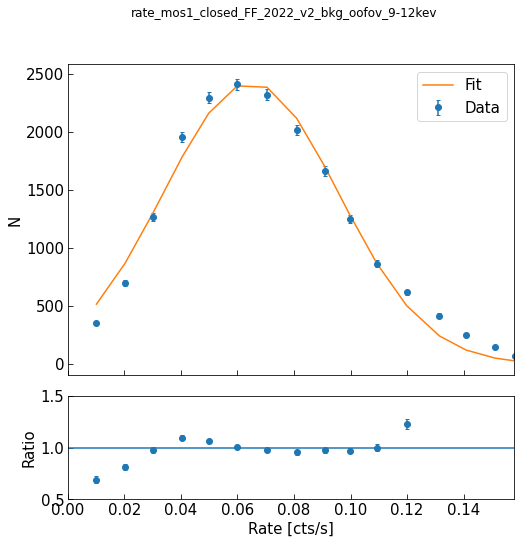

<Figure size 432x288 with 0 Axes>

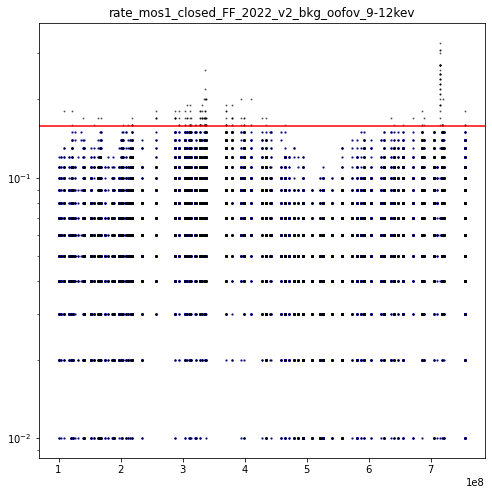

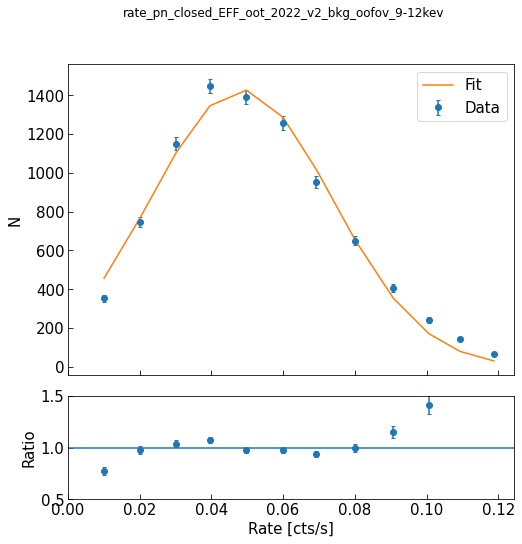

<Figure size 432x288 with 0 Axes>

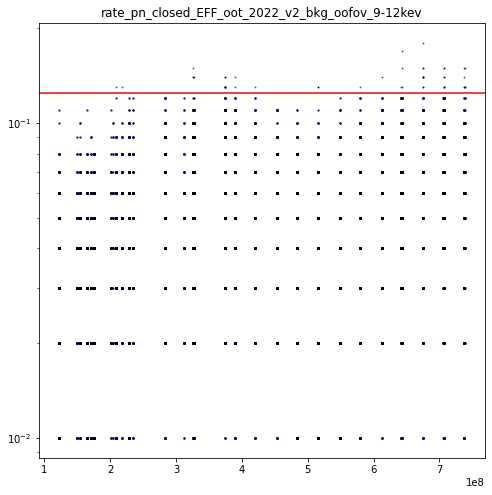

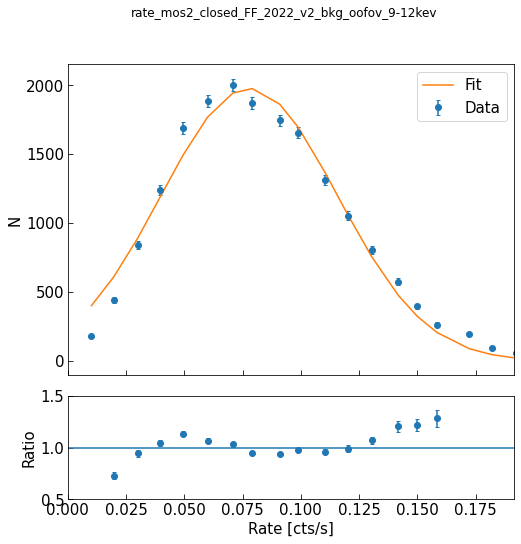

<Figure size 432x288 with 0 Axes>

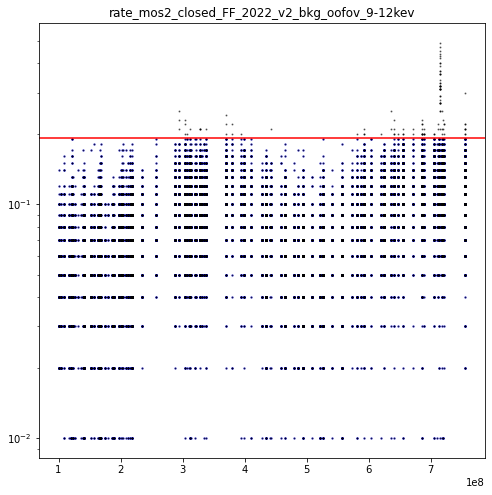

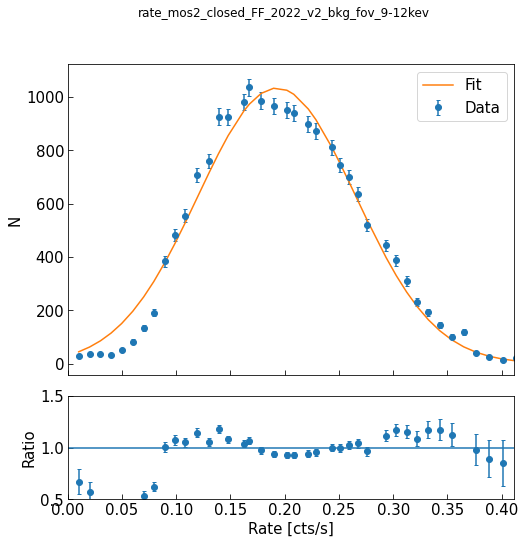

<Figure size 432x288 with 0 Axes>

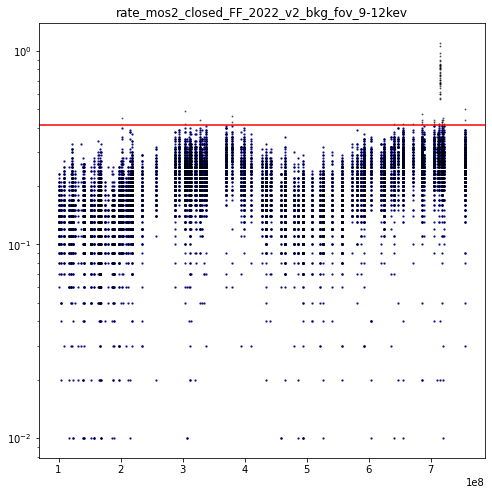

In [39]:
import datetime
from fit_gauss_to_lc import fit_lc_dirty, create_logfile

obs = 101
for file in files:
    file = file.split('/')[-1]
    hdul = fits.open(f'lc/{file}')
    dat = hdul[1].data
    hdul.close()
    logger = create_logfile('fit_lc_dirty', f'fit_lc_dirty.log')
    amp, mu, sigma, hist, bin_mid = fit_lc_dirty(1, file, f'{bkg_dir}/lc', 3, 120,  logger, figpath = '/stage/headat/yanling/XMM_datareduction/fig', PN_cts_limit=1.5, EMOS_cts_limit=1.5, PLOT=True)


# 4. filter bkg data based on gaussian fitting results

In [54]:
# Keep log file 
from glob import glob
f = open('bkg_gti.sh', 'w')


obs = 101
files = glob('events/pn_closed_EFF_2022_v2.fits.gz')
for file in files:
    inst = 'pn'
    hdul = fits.open(file)
    dat = hdul[1].data
    hdul.close()
    logger = create_logfile('fit_lc_dirty', f'fit_lc_dirty.log')
    lcfile = glob(f'lc/rate_*{inst}*fov*.fits')[0]
    amp, mu, sigma, hist, bin_mid = fit_lc_dirty(1, lcfile, f'{bkg_dir}', 3, 120,  logger, figpath = '/stage/headat/yanling/XMM_datareduction/fig', PN_cts_limit=1.5, EMOS_cts_limit=1.5, PLOT=False)
    print(f'tabgtigen table={lcfile} expression="RATE<={mu+3*sigma}" gtiset={inst}_bkg_gti.fits')
    f.write(f'tabgtigen table={file} expression="RATE<={mu+2*sigma}" gtiset={inst}_bkg_gti.fits')
f.close()

f = open('bkg_clean.sh', 'w')
for file in files:
        if 'mos' in file:
                ins = 'EM'
        
        else:
                ins = 'EP'
        print(f'evselect table={file} withfilteredset=Y filteredset={inst}_bkg_clean.fits destruct=Y \
                keepfilteroutput=T expression="gti({inst}_bkg_gti.fits,TIME)&&(PI>150)"')
        f.write(f'evselect table={file} withfilteredset=Y filteredset={inst}_bkg_clean.fits destruct=Y \
                keepfilteroutput=T expression="gti({inst}_bkg_gti.fits,TIME)&&(PI>150)"')
f.close()
                

tabgtigen table=lc/rate_pn_closed_EFF_oot_2022_v2_bkg_fov_9-12kev.fits expression="RATE<=0.7601617035271492" gtiset=pn_bkg_gti.fits
evselect table=events/pn_closed_EFF_2022_v2.fits.gz withfilteredset=Y filteredset=pn_bkg_clean.fits destruct=Y                 keepfilteroutput=T expression="gti(pn_bkg_gti.fits,TIME)&&(PI>150)"


# 5. scale counts rate of bkg at 9-12 keV from clean file

extract high energies from bkg clean event files

In [ ]:
bkg_dir = '/stage/headat/yanling/xmm/fwc_dat'
os.chdir(bkg_dir)
# after 2005, loss of emos1 ccd should be included
files = ['mos1_closed_FF_2022_v2', 'mos2_closed_FF_2022_v2', 'pn_closed_EFF_2022_v2', 'pn_closed_EFF_oot_2022_v2']

f = open('bkg_oofov_9-12_oofov_img.sh', 'w')
for file in files:
    if ('pn' in file):
        pattern = 4
        command = f'evselect table={file}_bkg_clean.fits withfilteredset=Y filteredset={file}_bkg_clean_9-12_oofov.fits \
            destruct=Y keepfilteroutput=T expression="#XMMEA_16&&(PATTERN<={pattern})&&(PI in [9000:12000])"'
        print(command)
        f.write(command)
    else:
        pattern = 12
        if ('mos1' in file):
            command = f'evselect table={file}_bkg_clean.fits withfilteredset=Y filteredset={file}_bkg_clean_9-12_oofov.fits destruct=Y \
                    keepfilteroutput=T expression="#XMMEA_16&&(PATTERN<={pattern})&&(PI in [9000:12000])\
                    &&(CCDNR.ne.6)"'
            print(command)
            f.write(command)
        else:
            command = f'evselect table={file}_bkg_clean.fits withfilteredset=Y filteredset={file}_bkg_clean_9-12_oofov.fits destruct=Y \
                    keepfilteroutput=T expression="#XMMEA_16&&(PATTERN<={pattern})&&(PI in [9000:12000])"' #&&region({region_file})
            print(command)
            f.write(command)

    command = f'evselect table={file}_bkg_clean_9-12_oofov.fits xcolumn=X ycolumn=Y imagebinning=binSize \
        ximagebinsize=20 yimagebinsize=20 withimageset=true imageset={file}_bkg_clean_9-12_oofov_img.fits'
    print(command)
    f.write(command)

f.close()
    


Calculate background counts


In [ ]:
files = ['mos1_closed_FF_2022_v2', 'mos2_closed_FF_2022_v2', 'pn_closed_EFF_2022_v2', 'pn_closed_EFF_oot_2022_v2']
os.chdir(bkg_dir)

f = open(f'{bkg_dir}/bkg_counts.log', 'w')
bkg_counts_list = np.zeros(len(files))
bkg_livetime_list = np.zeros(len(files))
for i, file in enumerate(files):
    fname = f'{file}_bkg_clean_9-12_oofov_img.fits'
    hdul = fits.open(fname)
    data = hdul[0].data
    bkg_counts = np.sum(data)
    hdul.close()

    # Read livetime for bkg
    fname = f'{file}_bkg_clean.fits'
    hdul = fits.open(fname)
    data = hdul[1].header
    bkg_livetime = data['LIVETI02']
    hdul.close()
    bkg_counts_list[i] = bkg_counts
    bkg_livetime_list[i] = bkg_livetime
    print(file, bkg_counts, bkg_livetime, bkg_counts/bkg_livetime)
    f.write(f'file, bkg_counts, bkg_livetime, bkg_counts/bkg_livetime')
    f.write(f'{file}, {bkg_counts}, {bkg_livetime}, {bkg_counts/bkg_livetime}')
f.close()


extract clean events and images from observation files

In [ ]:
data_dir = '/stage/headat/yanling/xmm/reduction_230227/101'
os.chdir(data_dir)
files = ['EMOS1', 'EMOS2', 'EPN', 'Oot']
f = open(f'{data_dir}/data_oofov_9-12_oofov_img.sh', 'w')

for file in files:
    if (file=='EPN') or (file=='Oot'):
        pattern=4
        print(f'evselect table={file}_clean.fits withfilteredset=Y filteredset={file}_oofov_clean.fits \
        destruct=Y keepfilteroutput=T expression="#XMMEA_16&&(PATTERN<={pattern})&&(PI in [9000:12000])"') #"#XMMEA_16&&(PATTERN<={pattern})&&(PI in [9000:12000])"
        print(f'evselect table={file}_oofov_clean.fits xcolumn=X ycolumn=Y imagebinning=binSize \
            ximagebinsize=20 yimagebinsize=20 withimageset=true imageset={file}_oofov_counts.img')
        f.write(f'evselect table={file}_clean.fits withfilteredset=Y filteredset={file}_oofov_clean.fits \
        destruct=Y keepfilteroutput=T expression="#XMMEA_16&&(PATTERN<={pattern})&&(PI in [9000:12000])"')
        f.write(f'evselect table={file}_oofov_clean.fits xcolumn=X ycolumn=Y imagebinning=binSize \
            ximagebinsize=20 yimagebinsize=20 withimageset=true imageset={file}_oofov_counts.img')
    else:
        pattern = 12
        if 'MOS1' in file:
            print(f'evselect table={file}_clean.fits withfilteredset=Y filteredset={file}_oofov_clean.fits destruct=Y \
                    keepfilteroutput=T expression="#XMMEA_16&&(PATTERN<={pattern})&&(PI in [9000:12000])\
                    &&(CCDNR.ne.6)"') # &&region({region_file})
            f.write(f'evselect table={file}_clean.fits withfilteredset=Y filteredset={file}_oofov_clean.fits destruct=Y \
                keepfilteroutput=T expression="#XMMEA_16&&(PATTERN<={pattern})&&(PI in [9000:12000])\
                &&(CCDNR.ne.6)"')
        else:
            print(f'evselect table={file}_clean.fits withfilteredset=Y filteredset={file}_oofov_clean.fits destruct=Y \
                    keepfilteroutput=T expression="#XMMEA_16&&(PATTERN<={pattern})&&(PI in [9000:12000])') # &&region({region_file})
            f.write(f'evselect table={file}_clean.fits withfilteredset=Y filteredset={file}_oofov_clean.fits destruct=Y \
                keepfilteroutput=T expression="#XMMEA_16&&(PATTERN<={pattern})&&(PI in [9000:12000])"')
        
        print(f'evselect table={file}_oofov_clean.fits xcolumn=X ycolumn=Y imagebinning=binSize \
            ximagebinsize=20 yimagebinsize=20 withimageset=true imageset={file}_oofov_counts.img')
        f.write(f'evselect table={file}_oofov_clean.fits xcolumn=X ycolumn=Y imagebinning=binSize \
            ximagebinsize=20 yimagebinsize=20 withimageset=true imageset={file}_oofov_counts.img')
f.close()


reproject the events 

In [57]:
'''
attra=24.429 attdec=-12.870 attapos=-60.977
attra=24.409 attdec=-12.943 attapos=-59.440
'''
files = glob(f'*clean.fits')
ralist = [24.409, 24.429]
declist = [-12.943, -12.870]
palist = [59.440, 60.977]

f = open('reproj_bkgevents.sh', 'w')
for j in range(2):
        obs = f'{j+1}01'
        ra = ralist[j]; dec = declist[j]; pa = palist[j]
        for file in files:
                filename = file.split('.')[0]
                os.system(f'cp {file} {filename}_obs{obs}_bkg_clean.fits')
                print(f'evproject eventset={filename}_obs{obs}_bkg_clean.fits attsource=fixed attra={ra} attdec={dec} attapos={pa}')
                f.write(f'evproject eventset={filename}_obs{obs}_bkg_clean.fits attsource=fixed attra={ra} attdec={dec} attapos={pa}\n')

f.close()


evproject eventset=mos2_bkg_clean_obs101_bkg_clean.fits attsource=fixed attra=24.409 attdec=-12.943 attapos=59.44
evproject eventset=oot_bkg_clean_obs101_bkg_clean.fits attsource=fixed attra=24.409 attdec=-12.943 attapos=59.44
evproject eventset=pn_bkg_clean_obs101_bkg_clean.fits attsource=fixed attra=24.409 attdec=-12.943 attapos=59.44
evproject eventset=mos1_bkg_clean_obs101_bkg_clean.fits attsource=fixed attra=24.409 attdec=-12.943 attapos=59.44
evproject eventset=mos2_bkg_clean_obs201_bkg_clean.fits attsource=fixed attra=24.429 attdec=-12.87 attapos=60.977
evproject eventset=oot_bkg_clean_obs201_bkg_clean.fits attsource=fixed attra=24.429 attdec=-12.87 attapos=60.977
evproject eventset=pn_bkg_clean_obs201_bkg_clean.fits attsource=fixed attra=24.429 attdec=-12.87 attapos=60.977
evproject eventset=mos1_bkg_clean_obs201_bkg_clean.fits attsource=fixed attra=24.429 attdec=-12.87 attapos=60.977


extract clean spectra within annuli regions 


In [59]:
# extract the spec at annuli
obs = 101
datafiles = glob(f'*clean*{obs}*.fits')
f = open(f'qbp_{obs}_data_spec.sh','w')
for datafile in datafiles:
    for i in range(5):
        inst = datafile.split('/')[-1].split('_')[0]
        regname = glob(f'regions/shocks_phy_{obs}_reg{int(i+1)}*.txt')[0]
        f1 = open(regname)
        lines = f1.readlines()
        f1.close()
        if 'mos1' in datafile:
            express = f"(FLAG==0) && (PATTERN<=12) && CCDNR.ne.6"
        elif 'mos2' in datafile:
            express = f"(FLAG==0) && (PATTERN<=12)"
        else: 
            express = f"(FLAG==0) && (PATTERN<=4)"
        for j, line in enumerate(lines):    
            if len(lines)>3:
                if j<=1:
                    express = express + line[:-2]
                elif (j>1) and j<len(lines)-1:
                    express = express + "&&" + line[:-2]
                else:
                    express = express+ "&&" + line[:-1]
            else:
                if j<1:
                    express = express + line[:-2]
                else:
                    express = express + line[:-1]
    
        # generate the events of [corner(_oofov)] and [all fov without corner region(_fov)]
        if 'MOS' in datafile:
            f.write(f'''
evselect table={datafile} withspectrumset=Y spectrumset=qbp_{inst}_{obs}_reg{int(i+1)}_spec.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=11999 expression="{express}"\n
            ''')
        else:
            f.write(f'''
evselect table={datafile} withspectrumset=Y spectrumset=qbp_{inst}_{obs}_reg{int(i+1)}_spec.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression="{express}"\n
            ''')
        # generate the corresponding images of previously generated events
        f.write(f'''
evselect table={datafile} xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 withimageset=Y imageset=qbp_{inst}_{obs}_reg{int(i+1)}_img.fits expression="{express}"\n''')
f.close()
# f = open('qbp_spec.sh')
# print(f.readlines())
# f.close()

extract clean spectra within bkg regions 


In [61]:
# extract the spec at data regions
obs = 101
datafiles = glob(f'*clean*{obs}*.fits')
f = open(f'qbp_{obs}_bkg_spec.sh','w')
for datafile in datafiles:
    inst = datafile.split('/')[-1].split('_')[0]

    if 'mos' in inst:
        regname = glob(f'regions/bkg_{obs}_all.reg')[0]
    else:
        regname = glob(f'regions/bkg_{obs}_pn.reg')[0]
    f1 = open(regname)
    lines = f1.readlines()
    f1.close()

    if 'mos1' in datafile:
        express = f"(FLAG==0) && (PATTERN<=12) && CCDNR.ne.6"
    elif 'mos2' in datafile:
        express = f"(FLAG==0) && (PATTERN<=12)"
    else: 
        express = f"(FLAG==0) && (PATTERN<=4)"
    for i, line in enumerate(lines):
        express = express + line[:-1]
    # generate the events of [corner(_oofov)] and [all fov without corner region(_fov)]
    if 'mos' in datafile:
        f.write(f'''
evselect table={datafile} withspectrumset=Y spectrumset=qbp_{inst}_{obs}_bkg_spec.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=11999 expression="{express}"\n
        ''')
    else:
        f.write(f'''
evselect table={datafile} withspectrumset=Y spectrumset=qbp_{inst}_{obs}_bkg_spec.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression="{express}"\n
        ''')
    # generate the corresponding images of previously generated events
    f.write(f'''
evselect table={datafile} xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 withimageset=Y imageset=qbp_{inst}_bkg_{obs}_img.fits expression="{express}"\n
    ''')

f.close()
f = open(f'qbp_{obs}_bkg_spec.sh')
print(f.readlines())
f.close()

['\n', 'evselect table=pn_bkg_clean_obs101_bkg_clean.fits withspectrumset=Y spectrumset=source_pn_101_bkg_spec.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression="(FLAG==0) && (PATTERN<=4)&&((X,Y) IN circle(14280.503,22120.496,3600))&&!((X,Y) IN ellipse(12634.451,24561.072,406.44,336.44,143.41351))&&!((X,Y) IN ellipse(14461.988,23707.064,296.82,204.48,28.197311))"\n', '\n', '        \n', 'evselect table=pn_bkg_clean_obs101_bkg_clean.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 withimageset=Y imageset=source_pn_bkg_101_img.fits expression="(FLAG==0) && (PATTERN<=4)&&((X,Y) IN circle(14280.503,22120.496,3600))&&!((X,Y) IN ellipse(12634.451,24561.072,406.44,336.44,143.41351))&&!((X,Y) IN ellipse(14461.988,23707.064,296.82,204.48,28.197311))"\n', '\n', '    \n', 'evselect table=oot_bkg_clean_obs101_bkg_clean.fits withspectrumset=Y spectrumset=source_oot_101_bkg_spec.fits energycolumn=PI spectralbinsi

check spectrum extract regions

In [8]:
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel
kernel = Gaussian2DKernel(x_stddev=1)
os.makedirs('png', exist_ok=True)
for file in glob(f'*img.fits'):
    print(file)
    title = file
    hdu = fits.open(f'{file}')[0]
    image_data = hdu.data
    print(image_data.shape)
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=WCS(f'{file}'))
    ra = ax.coords[0]
    dec = ax.coords[1]

    ra.set_axislabel('RA')
    dec.set_axislabel('Dec')
    image_data = np.where(np.isfinite(np.log10(image_data)), image_data, np.nan)
    astropy_conv = convolve(image_data, kernel)
    ax.set_title(title)
    print(np.nanmax(np.log10(image_data)), np.nanmin(np.log10(image_data)[image_data>0]))
    ax.matshow(np.log10(astropy_conv),  cmap='gnuplot2',origin='lower')
    # plt.colorbar()
    plt.savefig(f'png/{os.path.basename(file).split(".")[0]}.png')
    # plt.show()
    plt.close()


TypeError: 'module' object is not callable

extract oofov spectrum for scaling MOS

In [14]:
# extract the spec at oofov
from glob import glob
obs = 101
datafiles = glob(f'*clean*{obs}*.fits')
f = open(f'qbp_{obs}_oofov_spec.sh','w')
for datafile in datafiles:
    inst = datafile.split('/')[-1].split('_')[0]

    if 'mos1' in datafile:
        express = f"(PATTERN<=12) && CCDNR.ne.6"
    elif 'mos2' in datafile:
        express = f"(PATTERN<=12)"
    else: 
        express = f"(PATTERN<=4)"

    # generate the events of [corner(_oofov)] and [all fov without corner region(_fov)]
    if 'mos' in datafile:
        f.write(f'''
evselect table={datafile} withspectrumset=Y spectrumset=qbp_{inst}_{obs}_oofov_spec.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=11999 expression="#XMMEA_16&&{express}"\n
        ''')
    else:
        f.write(f'''
evselect table={datafile} withspectrumset=Y spectrumset=qbp_{inst}_{obs}_oofov_spec.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression="#XMMEA_16&&{express}"\n
        ''')
    # generate the corresponding images of previously generated events
    f.write(f'''
evselect table={datafile} xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 withimageset=Y imageset=qbp_{inst}_oofov_{obs}_img.fits expression="#XMMEA_16&&{express}"\n
    ''')

f.close()
f = open(f'qbp_{obs}_oofov_spec.sh')
print(f.readlines())
f.close()

['\n', 'evselect table=pn_bkg_clean_obs101_bkg_clean.fits withspectrumset=Y spectrumset=qbp_pn_101_oofov_spec.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression="#XMMEA_16&&(PATTERN<=4)"\n', '\n', '        \n', 'evselect table=pn_bkg_clean_obs101_bkg_clean.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 withimageset=Y imageset=qbp_pn_oofov_101_img.fits expression="#XMMEA_16&&(PATTERN<=4)"\n', '\n', '    \n', 'evselect table=oot_bkg_clean_obs101_bkg_clean.fits withspectrumset=Y spectrumset=qbp_oot_101_oofov_spec.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression="#XMMEA_16&&(PATTERN<=4)"\n', '\n', '        \n', 'evselect table=oot_bkg_clean_obs101_bkg_clean.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 withimageset=Y imageset=qbp_oot_oofov_101_img.fits expression="#XMMEA_16&&(PATTERN<=4)"\n', '\n', '    \n', 'ev

In [82]:
obs = 101
f = open(f'gen_arf_rmf_{obs}.sh', 'w')
set3="withrmfset=true extendedsource=yes detmaptype=flat withbadpixcorr=Y modeleffarea=Y modelquantumeff=Y modelfiltertrans=Y"

for inst in ['pn', 'oot', 'mos1', 'mos2']:
    f.write(f'''
rmfgen spectrumset=qpb_{inst}_{obs}_bkg_spec.fits rmfset=qpb_{inst}_{obs}_bkg.rmf detmaptype=flat extendedsource=yes badpixlocation={inst}_hiband_loband_clean_fov.fits\n
        ''')
    for reg in ['reg1', 'reg2', 'reg3', 'reg4', 'reg5']:
        f.write(f'''
rmfgen spectrumset=qpb_{inst}_{obs}_{reg}_spec.fits rmfset=qpb_{inst}_{obs}_{reg}.rmf detmaptype=flat extendedsource=yes badpixlocation={inst}_hiband_loband_clean_fov.fits\n
        ''')
f.close()
# f = open(f'gen_arf_rmf_{obs}.sh')
# print(f.readlines())

read averaged fwc for 2019v1 and 2022v2, define the scale

extract lc from 2019v1 

In [73]:
from datetime import datetime


# Example dates
epoch_time = datetime(1998, 1, 1, 0, 0, 0)
print(19.9831*365*24*60*60/1e8)

# print(23.5*365*24*60*60/1e8)


6.301870415999999
7.41096


In [77]:

print(f'''
evselect table=pn_bkg_clean.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 withimageset=Y imageset=qbp_2019v1_img.fits expression="(FLAG==0) && (PATTERN<=4) && (TIME<=6.302e8)"\n
    ''')
print(f'''
evselect table=pn_bkg_clean.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 withimageset=Y imageset=qbp_2022v2_img.fits expression="(FLAG==0) && (PATTERN<=4)"\n
    ''')


evselect table=pn_bkg_clean.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 withimageset=Y imageset=qbp_2019v1_img.fits expression="(FLAG==0) && (PATTERN<=4) && (TIME<=6.302e8)"

    

evselect table=pn_bkg_clean.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 withimageset=Y imageset=qbp_2022v2_img.fits expression="(FLAG==0) && (PATTERN<=4)"

    


In [79]:
# cts
cts_2019v1 = 4326490
cts_2022v2 = 6138138
exp_2019v1 = 6.96625881867573E+05
exp_2022v2 = 8.83538359438241E+05

print(cts_2022v2/exp_2022v2/(cts_2019v1/exp_2019v1))

# according to zhang2022
print(cts_2022v2/exp_2022v2/(cts_2019v1/exp_2019v1) * 1.15)

1.118600837951277
1.2863909636439685


read data counts

In [ ]:
# Read the counts
data_dir = '/stage/headat/yanling/xmm/reduction_230227/201'
os.chdir(data_dir)
f = open(f'{data_dir}/data_oofov_counts.log', 'w')

files = ['EMOS1', 'EMOS2', 'EPN', 'Oot']
obs_counts_list = np.zeros(len(files))
obs_livetime_list = np.zeros(len(files))
for i, instrument in enumerate(files):
    fname = glob.glob(instrument + '_oofov_*.img')[0]
    hdul = fits.open(fname)
    data = hdul[0].data
    obs_counts = np.sum(data)
    hdul.close()

    # Read livetime for source
    fname = instrument + '_clean.fits'
    hdul = fits.open(fname)
    data = hdul[1].header

    obs_livetime = data['LIVETI02']

    hdul.close()
    print(instrument, obs_counts, obs_livetime, obs_counts/obs_livetime)
    f.write('instrument, obs_counts, obs_livetime, obs_counts/obs_livetime\n')
    f.write(f'{instrument}, {obs_counts}, {obs_livetime}, {obs_counts/obs_livetime}\n')
    obs_counts_list[i] = obs_counts
    obs_livetime_list[i] = obs_livetime
f.close()

'''oofov area 
bkg
mos1_closed_FF_2022_v2 125161 1886442.17854285 0.06634764713365265
mos2_closed_FF_2022_v2 136006 1859701.47908783 0.07313324290450635
pn_closed_EFF_2022_v2 39345 739987.328768998 0.053169829361067796
pn_closed_EFF_oot_2022_v2 35303 740268.032837234 0.04768948331416362
101 obs 
EMOS1 3360 39004.5795996189 0.08614373067189345
EMOS2 4230 46478.1277415752 0.09101055067276771
EPN 1339 15959.1501955055 0.08390171052949275
Oot 1116 14977.9862565659 0.07450934864563513
201 obs 
EMOS1 3360 39004.5795996189 0.0850
EMOS2 4230 46478.1277415752 0.0984
EPN 1339 15959.1501955055 0.0830
Oot 1116 14977.9862565659 0.0789
'''
obs_counts_list = np.array(obs_counts_list)
obs_livetime_list = np.array(obs_livetime_list)
bkg_counts_list = np.array(bkg_counts_list)
bkg_livetime_list = np.array(bkg_livetime_list)
f = open(f'{bkg_dir}/bkg_oofov_9-12_ratio_counts.log', 'w')
f.write('instrument, ctr ratio, cts ratio')
f.write(f'{instrument},{(obs_counts_list/obs_livetime_list)/(bkg_counts_list/bkg_livetime_list)}, {(obs_counts_list)/(bkg_counts_list)}')
f.close()
print('ctr ratio:', (obs_counts_list/obs_livetime_list)/(bkg_counts_list/bkg_livetime_list), 'cts ratio:', (obs_counts_list)/(bkg_counts_list))

# 6. Generate scaled bkg cts image

Reproject background events 

In [ ]:
'''
attra=24.429 attdec=-12.870 attapos=-60.977
attra=24.409 attdec=-12.943 attapos=-59.440
'''
f = open(f'{bkg_dir}/bkg_reproj_evt.sh', 'w')
bkg_dir = '/stage/headat/yanling/xmm/fwc_dat'
os.chdir(bkg_dir)
# files = ['mos1_closed_FF_2022_v2', 'mos2_closed_FF_2022_v2', 'pn_closed_EFF_2022_v2', 'pn_closed_EFF_oot_2022_v2']
files = ['mos2_closed_FF_2022_v2']
ralist = [24.409, 24.429]
declist = [-12.943, -12.870]
palist = [59.440, 60.977]

for j in range(2):
        obs = f'{j+1}01'
        ra = ralist[j]; dec = declist[j]; pa = palist[j]
        for i in range(len(files)):
                os.system(f'cp {files[i]}_bkg_clean.fits {files[i]}_obs{obs}_bkg_clean.fits')
                print(f'evproject eventset={files[i]}_obs{obs}_bkg_clean.fits attsource=fixed attra={ra} attdec={dec} attapos={pa}')
                f.write(f'cp {files[i]}_bkg_clean.fits {files[i]}_obs{obs}_bkg_clean.fits\n')
                f.write(f'evproject eventset={files[i]}_obs{obs}_bkg_clean.fits attsource=fixed attra={ra} attdec={dec} attapos={pa}\n')

f.close()


extract and scale the bkg images

In [ ]:
bkg_dir = '/stage/headat/yanling/xmm/fwc_dat'
os.chdir(bkg_dir)
files = ['mos1_closed_FF_2022_v2', 'mos2_closed_FF_2022_v2', 'pn_closed_EFF_2022_v2', 'pn_closed_EFF_oot_2022_v2']
scales_dir = {'101':[0.02684542, 0.02770809, 0.02605008, 0.02399071], 
    '201':[0.02864311, 0.02867754, 0.04227544, 0.04520831]}
os.chdir(bkg_dir)

for obs in [101, 201]:
    for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000']:
        blo = band.split('-')[0]
        bhi = band.split('-')[1]

        scales = scales_dir[str(obs)]
        f = open(f'{bkg_dir}/bkg_img_obs{obs}_{blo}-{bhi}.sh', 'w')
        for i, file in enumerate(files):
            evtfile = f'{file}_obs{obs}_bkg_clean'
            imgfile = f'{evtfile}_{blo}-{bhi}'
            if ('pn' in file):
                ins = 'EP'
                pattern = 4
                print(f'evselect table={evtfile}.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 \
yimagebinsize=80 withimageset=true imageset={imgfile}.img expression="#XMMEA_{ins}&&(PATTERN<={pattern})&&(PI>={blo})&&(PI<={bhi})"')
                f.write(f'evselect table={evtfile}.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 \
yimagebinsize=80 withimageset=true imageset={imgfile}.img expression="#XMMEA_{ins}&&(PATTERN<={pattern})&&(PI>={blo})&&(PI<={bhi})"\n')
            else:
                ins = 'EM'
                pattern = 12
                if 'mos1' in file:
                    print(f'evselect table={evtfile}.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 \
yimagebinsize=80 withimageset=true imageset={imgfile}.img expression="#XMMEA_{ins}&&(PATTERN<={pattern})&&(PI>={blo})&&(PI<={bhi})&&(CCDNR.ne.6)"')
                    f.write(f'evselect table={evtfile}.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 \
yimagebinsize=80 withimageset=true imageset={imgfile}.img expression="#XMMEA_{ins}&&(PATTERN<={pattern})&&(PI>={blo})&&(PI<={bhi})&&(CCDNR.ne.6)"\n')
                else:
                    print(f'evselect table={evtfile}.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 \
yimagebinsize=80 withimageset=true imageset={imgfile}.img expression="#XMMEA_{ins}&&(PATTERN<={pattern})&&(PI>={blo})&&(PI<={bhi})\n"')
                    f.write(f'evselect table={evtfile}.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 \
yimagebinsize=80 withimageset=true imageset={imgfile}.img expression="#XMMEA_{ins}&&(PATTERN<={pattern})&&(PI>={blo})&&(PI<={bhi})"\n')
            
            print(f'farith {imgfile}.img {scales[i]} {imgfile}_scaled.img "*" clobber=yes')
            f.write(f'farith {imgfile}.img {scales[i]} {imgfile}_scaled.img "*" clobber=yes\n')
        f.close()

manage pn image (substract oot data)

In [ ]:
bkg_dir = '/stage/headat/yanling/xmm/fwc_dat'
os.chdir(bkg_dir)
f = open('bkg_pn_oot_corr.sh', 'w')
for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000']:
      blo = band.split('-')[0]
      bhi = band.split('-')[1]
      frame = 'eff'
      # Scale OoT image
      for obs in [101,201]:
            pn_imgname = f'pn_closed_EFF_2022_v2_obs{obs}_bkg_clean_{blo}-{bhi}_scaled'
            oot_imgname = f'pn_closed_EFF_oot_2022_v2_obs{obs}_bkg_clean_{blo}-{bhi}_scaled'
            if(frame == 'eff'):
                  print(f'farith {oot_imgname}.img 0.023 {oot_imgname}_corr.img MUL clobber=yes')
                  f.write(f'farith {oot_imgname}.img 0.023 {oot_imgname}_corr.img MUL clobber=yes\n')
                  
            elif(frame == 'ff'):
                  print(f'farith {oot_imgname}.img 0.063 {oot_imgname}_corr.img MUL clobber=yes')
                  f.write(f'farith {oot_imgname}.img 0.063 {oot_imgname}_corr.img MUL clobber=yes\n')

            print(f'farith {pn_imgname}.img {oot_imgname}_corr.img {pn_imgname}_corr.img SUB clobber=yes')
            f.write(f'farith {pn_imgname}.img {oot_imgname}_corr.img {pn_imgname}_corr.img SUB clobber=yes\n')
f.close()

check bkg images

In [ ]:
# from astropy.visualization import astropy_mpl_style
import matplotlib.colors as colors
# plt.style.use(astropy_mpl_style)
plt.style.use('default')
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel
kernel = Gaussian2DKernel(x_stddev=1)

file = f'{bkg_dir}/mos2_closed_FF_2022_v2_obs201_bkg_clean_700-1200_scaled'
# file = 'EPN_corr_counts'
hdu = fits.open(f'{file}.img')[0]
image_data = hdu.data
print(image_data.shape)
fig = plt.figure(figsize = (6,6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=WCS(f'{file}.img'))
ra = ax.coords[0]
dec = ax.coords[1]
# plt.grid(color='grey', ls='dashed')
plt.grid('off')
ra.set_axislabel('RA')
dec.set_axislabel('Dec')
'''
ra.set_ticks_visible(True)
dec.set_ticks_visible(True)
ra.display_minor_ticks(True)
dec.display_minor_ticks(True)
ra.set_ticks_position('all')
ra.set_ticks(number=4)
dec.set_ticks(number=4)
'''
image_data = np.where(np.isfinite(np.log10(image_data)), image_data, np.nan)
astropy_conv = convolve(image_data, kernel)
plt.imshow(astropy_conv, cmap='gnuplot2', norm = colors.LogNorm(vmin = 1e-1, vmax = 1), origin='lower')
plt.colorbar()
plt.savefig(f'{file}.png')
plt.show()
plt.clf()
print(np.min(np.log10(image_data[50:550,50:550])))